In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load output
df = pd.read_json("../output.json").T
df.head()

,trajectory,agent_state_items,agent_state_item_levels
0,"[{'state': {'food': 0, 'water': 0, 'min_steps_...",None,None
1,"[{'state': {'food': 0, 'water': 0, 'min_steps_...",None,None
2,"[{'state': {'food': 0, 'water': 0, 'min_steps_...",None,None
3,"[{'state': {'food': 0, 'water': 0, 'min_steps_...",None,None
4,"[{'state': {'food': 0, 'water': 0, 'min_steps_...",None,None


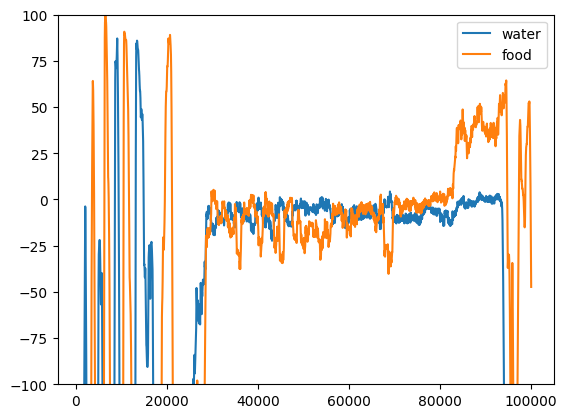

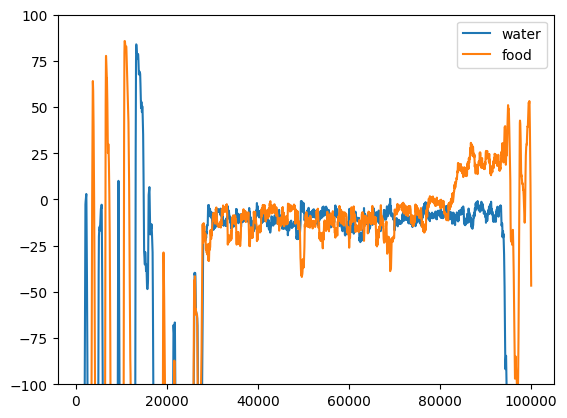

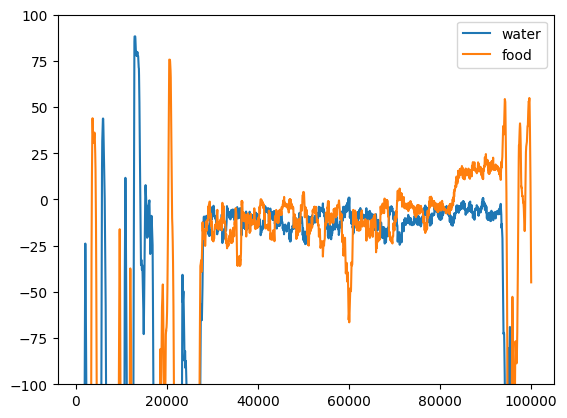

In [3]:
def plot_food_and_water(df, agent_idx):
    df2 = pd.DataFrame.from_records(df["trajectory"].iloc[agent_idx])
    # Expand records
    df2 = df2.join(pd.DataFrame.from_records(df2["state"])).join(pd.DataFrame.from_records(df2["reward"]))
    window = 1000
    df2["water"].rolling(window).mean().plot()
    df2["food"].rolling(window).mean().plot()
    plt.gca().set_ylim(-100, 100)
    plt.legend()

# Plot 3 agents
for i in range(0, 3):
    plot_food_and_water(df, i)
    plt.show()


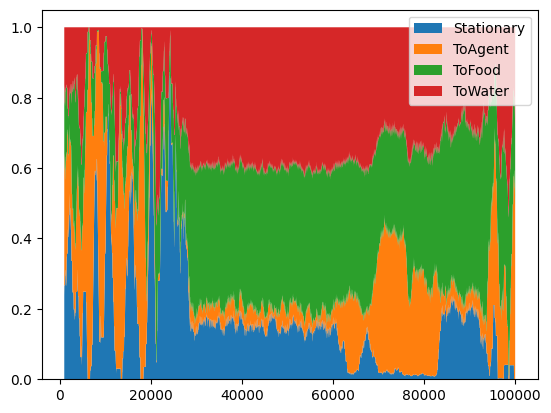

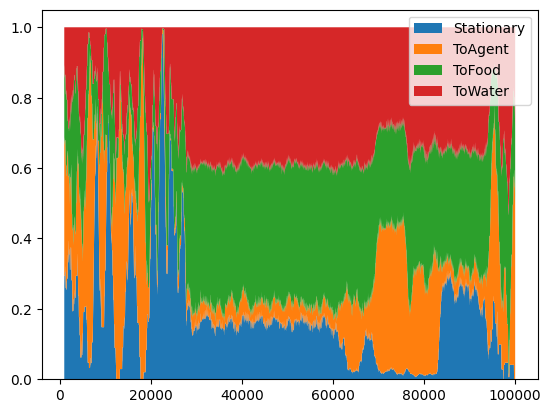

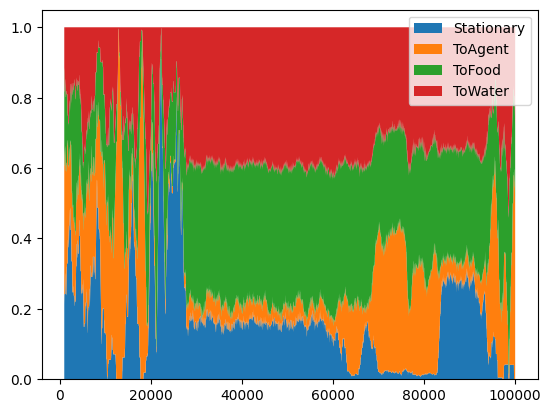

In [4]:
def plot_actions(df, agent_idx):
    df2 = pd.DataFrame.from_records(df["trajectory"].iloc[agent_idx])
    df3 = pd.get_dummies(df2["action"], drop_first=False).eq(True).mul(1)
    plt.stackplot(np.arange(df3.shape[0]), *[arr for arr in df3.rolling(1000).mean().T.values], labels=df3.columns)
    plt.legend()
    plt.show()

# Plot 3 agents
for i in range(3):
    plot_actions(df, i)